_NOTE: THIS WORKBOOK IS UNDER DEVELOPMENT._

# Base Turbine Productivity Report

## Purpose
Use this analysis tool to evaluate a few hundred wind turbines and identify specific turbines with performance or operational issues.

## Getting Started
You're most of the way there already.  
1. Make sure you have followed the [install instructions](https://openoa.readthedocs.io/en/latest/install.html) from the main OpenOA documentation. 
2. Please have prepared a csv of turbine data with: 
    * the columns listed in "Provide A Little Information" section below (at minimum)
    * each row is a ten minute average
    * all turbines' data combined into the one file
3. Provide the little information below
4. Run the rest of the notebook. Usually selecting `Cell > Run All Below` from the menu is the easiest. 


## Provide a Little Information

Please specify the path to your CSV file and some column name information below. 

In [69]:

# full path and file name to CSV file
scadaCSVpath = "./data/scada_10min_4cols.csv" 

# Column Mapping
columnNames = {
                "time": "dttm" # timestamps 
                , "id": "id" # turbine ID
                , "windspeed_ms": "wind_speed" # wind speed
                , "power_kw": "kw" # power
                , "pitch_deg": "" # blade pitch
                , "winddirection_deg": "nacelle_position" # the wind direction or proxy for it such as nacelle direction
                , "temp_c" : "" # temperature
            }




-------
## LET IT RIP!
Select `Cell > Run All Below` to execute the rest of this notebook. Grab a coffee.  When this is done, hit `File > Download As` to save the results as HTML or PDF.  

 <tr>
    <td><img src=https://publicdomainvectors.org/photos/1294538687.png width=100></td>
    <td><img src=https://publicdomainvectors.org/photos/1294538687.png width=100></td>
    <td><img src=https://publicdomainvectors.org/photos/1294538687.png width=100></td>
 </tr>

In [72]:
from turbine_project import TurbineExampleProject
import os

path = os.path.dirname(os.path.abspath(scadaCSVpath))
fName = os.path.basename(os.path.abspath(scadaCSVpath))
fName = os.path.splitext(fName)[0]

turbine = TurbineExampleProject(path = path, fileName = fName, columnMapping = columnNames)
turbine.prepare()

display(turbine.scada.head())

INFO:operational_analysis.types.timeseries_table:Loading name:scada_10min_4cols


,id,time,windspeed_ms,power_kw,winddirection_deg,energy_kwh
time,,,,,,
2010-02-17 19:30:00,1,2010-02-17 19:30:00,0.63,-2.07,0.0,-0.345000
2010-02-17 19:40:00,1,2010-02-17 19:40:00,1.81,-2.24,0.0,-0.373333
2010-02-17 19:50:00,1,2010-02-17 19:50:00,2.13,-3.10,0.0,-0.516667
2010-02-17 20:00:00,1,2010-02-17 20:00:00,1.33,-1.91,0.0,-0.318333
2010-02-17 20:10:00,1,2010-02-17 20:10:00,0.63,-1.89,0.0,-0.315000


--------------
![](https://as1.ftcdn.net/jpg/02/80/66/50/500_F_280665078_EmmP78shvo6cVxXAANy5mc7SmxmDPszU.jpg)
# _**THE CODE BELOW HERE IS JUST FOR DEV, SHOWING CONCEPT**_
Where the concept is:
1. modify existing one turbine example heavility
2. extend with additional existing functionality
3. package nicely for a later save as HTML or PDF

_** Plan for rest of this workbook **_

1. Apply basic filters but add inidcators instead of removing rows right now.  Later methods can dictate their own filtering criteria
    * ON-OFF Inidcator (This is existing functionality)
    * WIND-SPEED Range Inidcator (This is existing functionality)
    * Boundary Curve Indicator (This is existing functionality)
2. Create some power benchmarks with discovered empirical power curve (This is existing functionality)
3. Categorize recrods per standard (at least at highest level)
4. Summarize time and lost energy by category and by asset

In [73]:
windspeed = turbine.scada.df["windspeed_ms"]
power_kw = turbine.scada.df["power_kw"]
turbine_id = turbine.scada.df["id"]
unique_turbine_ids = tubineID.unique()
df = turbine.scada.df
turbine_id

time
2010-02-17 19:30:00    1
2010-02-17 19:40:00    1
2010-02-17 19:50:00    1
2010-02-17 20:00:00    1
2010-02-17 20:10:00    1
                      ..
2018-01-13 00:50:00    3
2018-01-13 01:00:00    3
2018-01-13 01:10:00    3
2018-01-13 01:20:00    3
2018-01-13 01:30:00    3
Name: id, Length: 1007556, dtype: int64

## Filter the Data

The filtering toolkit implements commonly used filters and operated by returning a boolean series called "flag" which can be used to index the original dataframe. We start by importing the filtering toolkit:

In [74]:
from operational_analysis.toolkits import filters

First let's define a plotting function for the turbine power curve which we can use to examine the effect of different filtering functions on the data

In [75]:
import numpy as np
import matplotlib.pyplot as plt

In [76]:
def plot_flagged_pc(ws, p, flag_bool, alpha, title):
    plt.scatter(ws, p, s = 1, alpha = alpha)
    plt.scatter(ws[flag_bool], p[flag_bool], s = 1, c = 'red')
    plt.xlabel('Wind speed (m/s)')
    plt.ylabel('Power (kW)')
    plt.title(title)
    plt.show()

Now first let's take a look at the unprocessed data:

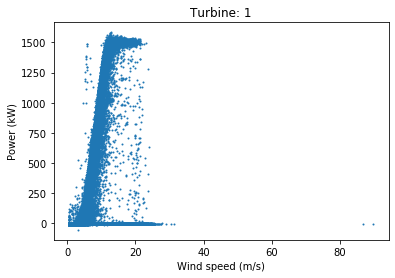

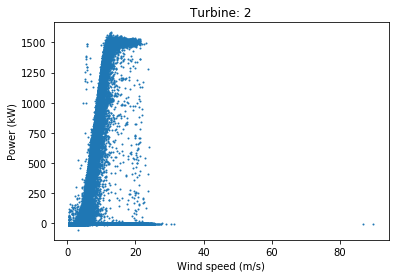

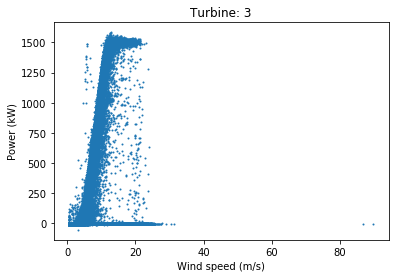

In [77]:
for t in unique_turbine_ids:
    ws = windspeed[turbine_id == t]
    p = power_kw[turbine_id == t]
    title = 'Turbine: ' + str(t)
    plot_flagged_pc(ws, p, np.repeat('True', df.shape[0]), 1, title)

### Range Filter

We immediately see two high wind speed outliers likely due to sensor malfunction. We can flag and filter these outliers from the dataset using the 'range_flag' function:

In [78]:
# Show outliers
out_of_range = filters.range_flag(windspeed, below=0, above=70)
windspeed[out_of_range].head()

time
2017-02-03 20:00:00    89.79
2017-02-03 20:10:00    86.67
2017-02-03 20:00:00    89.79
2017-02-03 20:10:00    86.67
2017-02-03 20:00:00    89.79
Name: windspeed_ms, dtype: float64

Let's remove the outliers and plot the result:

In [79]:
# Remove outliers
windspeed = windspeed[~out_of_range]
power_kw = power_kw[~out_of_range]
turbine_id = turbine_id[~out_of_range]
turbine_id.unique()

array([1, 2, 3])

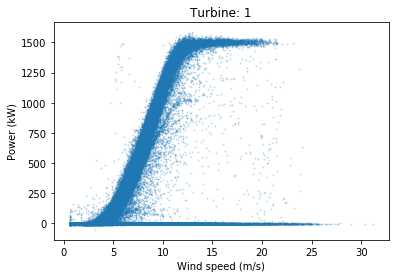

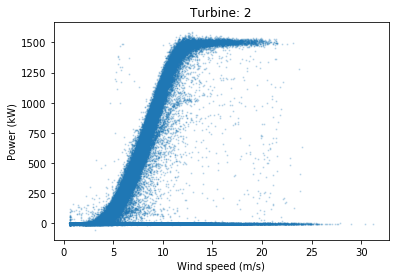

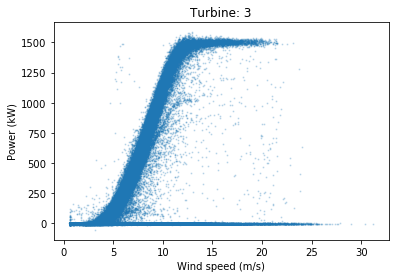

In [81]:
# Show updated power curve
for t in unique_turbine_ids:
    ws = windspeed[turbine_id == t]
    p = power_kw[turbine_id == t]
    title = 'Turbine: ' + str(t)
    plot_flagged_pc(ws, p, np.repeat('True', df.shape[0]), 0.2, title)

### Window Range Filter

We may want to remove turbine downtime events, which we can identify as near zero power at high wind speeds. We can do this using the 'window_range function' and removing data greater than 6 m/s but with power less than 20 kW:

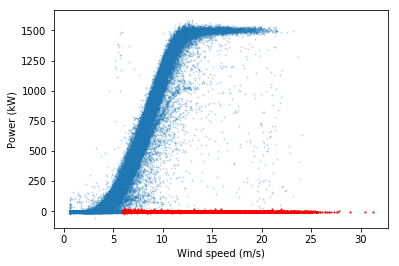

In [11]:
out_of_window = filters.window_range_flag(windspeed, 6., 40, power_kw, 20., 2000.)
plot_flagged_pc(windspeed, power_kw, out_of_window, 0.2)

Again, let's remove these flagged data from consideration:

In [12]:
windspeed = windspeed[~out_of_window]
power_kw = power_kw[~out_of_window]

### Bin Filter

We may be interested in fitting a power curve to data representing 'normal' turbine operation. In other words, we want to flag all anomalous data or data represenatative of underperformance. To do this, the 'bin_filter' function is useful. It works by binning the data by a specified variable, bin width, and start and end points. The criteria for flagging is based on some measure (scalar or standard deviation) from the mean or median of the bin center. 

As an example, let's bin on power in 100 kW increments, starting from 25.0 kW but stopping at 90% of peak power (i.e. we don't want to flag all the data at peak power and high wind speed. Let's use a scalar threshold of 1.5 m/s from the median for each bin. Let's also consider data on both sides of the curve by setting the 'direction' parameter to 'all'

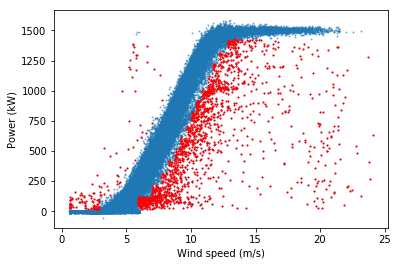

In [13]:
max_bin = 0.90*power_kw.max()
bin_outliers = filters.bin_filter(power_kw, windspeed, 100, 1.5, 'median', 20., max_bin, 'scalar', 'all')
plot_flagged_pc(windspeed, power_kw, bin_outliers, 0.5)

As seen above, one call for the bin filter has done a decent job of cleaning up the power curve to represent 'normal' operation, without excessive removal of data points. There are a few points at peak power but low wind speed that weren't flagged, however. Let catch those, and then remove those as well as the flagged data above, and plot our 'clean' power curve 

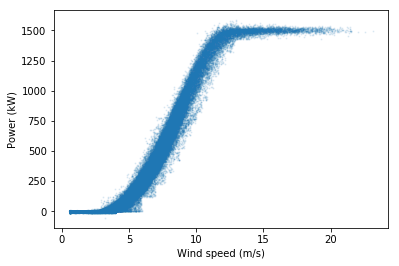

In [14]:
out_of_window = filters.window_range_flag(windspeed, 4., 8., power_kw, 0., 1250.)
windspeed = windspeed[(~out_of_window) & (~bin_outliers)]
power_kw = power_kw[(~out_of_window) & (~bin_outliers)]
plot_flagged_pc(windspeed, power_kw, np.repeat('True', len(windspeed)), 0.1)

The bin filter gives a bit of a 'choppy' look to the power curve at lower wind speeds, which we could clean up by using a smaller bin size.

### Unresponsive Filter

As a final filtering demonstration, we can look for an unrespsonsive sensor (i.e. repeating measurements). In this case, let's look for 3 or more repeating wind speed measurements:

In [15]:
frozen = filters.unresponsive_flag(windspeed, 3)
windspeed[frozen].head()

time
2010-02-18 02:10:00    0.63
2010-02-18 02:20:00    0.63
2010-02-18 02:30:00    0.63
2010-02-18 02:40:00    0.63
2010-02-18 02:50:00    0.63
Name: windspeed_ms, dtype: float64

We actually found a lot, so let's remove these data as well before moving on to power curve fitting.

In [16]:
windspeed = windspeed[~frozen]
power_kw = power_kw[~frozen]

## Fit the Power Curves

Now that our data has been reasonably processed, we can fit a power curve model to the data. Here we illustrate three types of power curves: the standard IEC binned power curve model, a spline fit, and a Logistic 5 parameter model (L5P):

In [17]:
from operational_analysis.toolkits import power_curve

In [18]:
# Fit the power curves
iec_curve = power_curve.IEC(windspeed, power_kw)
l5p_curve = power_curve.logistic_5_parametric(windspeed, power_kw)
spline_curve = power_curve.spline_fit(windspeed, power_kw, n_splines = 20)

100% (11 of 11) |#########################| Elapsed Time: 0:00:39 Time: 0:00:39


c:\nrel\pruf\git_work\final_v1\operational-analysis\operational_analysis\toolkits\power_curve\parametric_forms.py:35: RuntimeWarning: divide by zero encountered in power
  return d+(a-d)/(1+(x/c)**b)**g


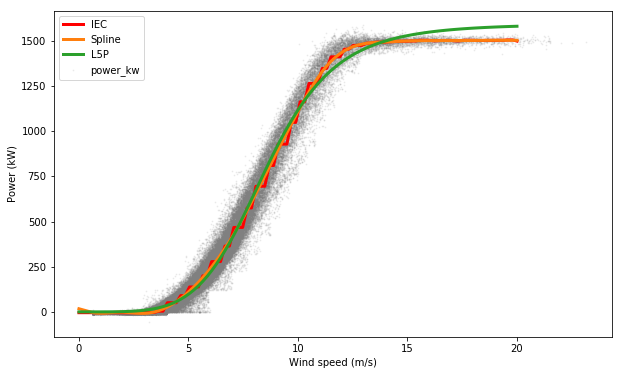

In [19]:
# Plot the results
x = np.linspace(0,20,100)
plt.figure(figsize = (10,6))
plt.scatter(windspeed, power_kw, alpha=0.1, s = 1, c = 'gray')
plt.plot(x, iec_curve(x), color="red", label = 'IEC', linewidth = 3)
plt.plot(x, spline_curve(x), color="C1", label = 'Spline', linewidth = 3)
plt.plot(x, l5p_curve(x), color="C2", label = 'L5P', linewidth = 3)
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Power (kW)')
plt.legend()
plt.show()

The above plot shows that both the IEC and spline method accurately capture the power curve (although the IEC method results in a 'choppy' fit), while the L5P model (constrained by its parametric form) deviates from the knee of the power curve through peak production.

### Relative Speed of Power Curve Fitting

We also note the speed of the computations. The IEC method is by far the fastest, followed by the spline fit, and then the L5P model.

In [20]:
import time

In [21]:
start = time.time()
power_curve.IEC(windspeed, power_kw)
end = time.time()
print 'IEC: ' + str(np.round(end - start, 3)) + ' seconds'

IEC: 0.329 seconds


In [22]:
start = time.time()
power_curve.spline_fit(windspeed, power_kw, n_splines=20)
end = time.time()
print 'Spline: ' + str(np.round(end - start, 3)) + ' seconds'

100% (11 of 11) |#########################| Elapsed Time: 0:00:36 Time: 0:00:36


Spline: 36.868 seconds


In [23]:
start = time.time()
power_curve.logistic_5_parametric(windspeed, power_kw)
end = time.time()
print 'L5P: ' + str(np.round(end - start, 3)) + ' seconds'

L5P: 100.295 seconds


In [24]:
l5p_curve(x)

array([  1.00000000e-03,   1.03011480e-03,   1.77179131e-03,
         6.14692843e-03,   2.07796894e-02,   5.71985631e-02,
         1.32906149e-01,   2.72362178e-01,   5.07901585e-01,
         8.80598939e-01,   1.44108381e+00,   2.25030616e+00,
         3.38024512e+00,   4.91454824e+00,   6.94908078e+00,
         9.59235578e+00,   1.29658054e+01,   1.72038424e+01,
         2.24536467e+01,   2.88746014e+01,   3.66372849e+01,
         4.59219198e+01,   5.69161690e+01,   6.98121705e+01,
         8.48027139e+01,   1.02076486e+02,   1.21812356e+02,
         1.44172739e+02,   1.69296159e+02,   1.97289251e+02,
         2.28218548e+02,   2.62102551e+02,   2.98904663e+02,
         3.38527646e+02,   3.80810290e+02,   4.25526877e+02,
         4.72389877e+02,   5.21056060e+02,   5.71135891e+02,
         6.22205725e+02,   6.73822042e+02,   7.25536698e+02,
         7.76912101e+02,   8.27535226e+02,   8.77029556e+02,
         9.25064309e+02,   9.71360590e+02,   1.01569446e+03,
         1.05789713e+03,